### This is the package inspired by the open-source libraries such PyTorch Lightning and of course d2l.
### On the wish to have three classes:
### (1)Module contains models, losses and optimization methods;
### (2)DataMoudle provides data loaders for training and validation;
### (3)both classes are combined using the Training class, which allows us to train models on a variety of hardware platforms, cpus and gpus,for example. It also contains optimization algorithms. 

In [1]:
import time 
import zipfile
import collections
import numpy
import inspect
from IPython import display
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline


reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)


In [ ]:
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform(module.weight)

In [2]:
def cpu():
    return torch.device('cpu')

def gpu(i=0):
    return torch.device(f'cuda:{i}')

def try_gpu(i=0):
    if torch.cuda.device_count() >= i+1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    return [gpu(i) for i in range(torch.cuda.device_count())]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.75):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = numpy(img)
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def use_svg_display():
    backend_inline.set_matplotlib_formats('svg')

In [3]:
class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class ProgressBoard(HyperParameters):
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

In [4]:
class Module(nn.Module, HyperParameters):
    def __init__(self, plot_train_per_epoch=1, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    
    def loss(self, y_hat, y):
        raise NotImplementedError

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)
    
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, numpy(to(value, cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
                        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr = self.lr)


In [5]:
class DataModule(HyperParameters):
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [6]:
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus = 1, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus = [gpu(i) for i in range(min(num_gpus, torch.cuda.device_count()))]
    
    def prepare_batch(self, batch):
        if self.gpus:
            batch = [a.to(self.gpus[0]) for a in batch]
        return batch
    
    def prepare_model(self, model):
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader) if self.val_dataloader is not None else 0)
    
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            global loss
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

In [7]:
class Classifier(Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged = True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare
    
    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = reshape(Y, (-1,))
        return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')
        
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)           

In [8]:
class FashionMNIST(DataModule):
    def __init__(self, batch_size=64, resize=(28,28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform = trans, download = True)

    def text_label(self, indices):
        labels = ['t-shirt', 'trousers', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size-1, shuffle=train, num_workers=12)
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X,y = batch
        if not labels:
            labels = self.text_label(y)
        show_images(X.squeeze(1), nrows, ncols, titles=labels)

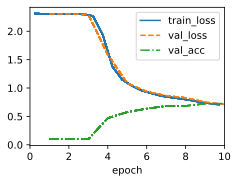

In [9]:
# def init_cnn(module):
#     if type(module) == nn.Linear or type(module) == nn.Conv2d:
#         nn.init.xavier_uniform(module.weight)
# class LeNet(Classifier):
#     def __init__(self, lr=0.1, num_classes=10):
#         super().__init__()
#         self.save_hyperparameters()
#         self.net = nn.Sequential(
#             nn.LazyConv2d(6, kernel_size=5, padding=2),
#             nn.Sigmoid(),
#             nn.AvgPool2d(kernel_size=2, stride=2),

#             nn.LazyConv2d(16, kernel_size=5),
#             nn.Sigmoid(),
#             nn.AvgPool2d(kernel_size=2, stride=2),
            
#             nn.Flatten(),
#             nn.LazyLinear(120),
#             nn.Sigmoid(),
#             nn.LazyLinear(84),
#             nn.Sigmoid(),
#             nn.LazyLinear(num_classes)
#         )
# trainer = Trainer(max_epochs=10, num_gpus=1)
# data = FashionMNIST(batch_size=128)
# model = LeNet(lr = 0.1)
# model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
# trainer.fit(model, data)
